In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from patchify import (patchify, unpatchify)
from utils import center_crop, rebuild_from_patches
from IPython.display import clear_output

In [ ]:
# Display a list with the available models and ask the user to choose which to use
models_path = 'trained_models/cropped_001'
models_list = os.listdir(models_path)

# create a dictionary with numbers as keys and the model names as values
models2dict = dict([(str(a), b) for a, b in enumerate(models_list)])

print('List of Models', '--------------', sep='\n')
for item in models2dict.items():
    print(*item, sep=' --> ')

print('\nChoose a model from the list by typing the number of its key + Enter:')
model_name = models2dict[input()]
clear_output()
print(f'\n{model_name} was selected.')

In [ ]:
# Load the model
model = keras.models.load_model(os.path.join(models_path, model_name))

In [4]:
# Retrieve the input layer and extract the size of width of the images (which is equal to the height)
input_layer = model.get_layer(index=0)
input_size = input_layer.input_shape[0][1]

In [5]:
# Load the input and ground truth images 
x_initial_valid = plt.imread('validation/201-INPUT.jpg')
y_initial_valid = plt.imread('validation/201-OUTPUT-GT.png')

CROP_SIZE_W = 3000 
CROP_SIZE_H = 3000

x_initial_valid = center_crop(x_initial_valid, (CROP_SIZE_H, CROP_SIZE_W))
y_initial_valid = center_crop(y_initial_valid, (CROP_SIZE_H, CROP_SIZE_W))

In [6]:
print(x_initial_valid.shape)
print(y_initial_valid.shape)

(3000, 3000, 3)
(3000, 3000)


In [7]:
# Create patches from the input and ground truth images
STEP = 128
input_patches = np.squeeze(patchify(x_initial_valid, (input_size, input_size, 3), step=STEP))
ground_truth_patches = np.squeeze(patchify(y_initial_valid, (input_size, input_size), step=STEP))

In [8]:
predictions = np.squeeze(model.predict(np.reshape(input_patches, (-1, input_size, input_size, 3))))
predictions = np.reshape(predictions, ground_truth_patches.shape)

2022-05-25 02:20:53.245696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


16/16 [==============================] - 3s 64ms/step


In [9]:
overlapped_images = int(np.power((input_size / STEP), 2))
unified_predictions = rebuild_from_patches(predictions, y_initial_valid.shape, STEP, input_size)
print(unified_predictions.shape)

(2688, 2688, 4)


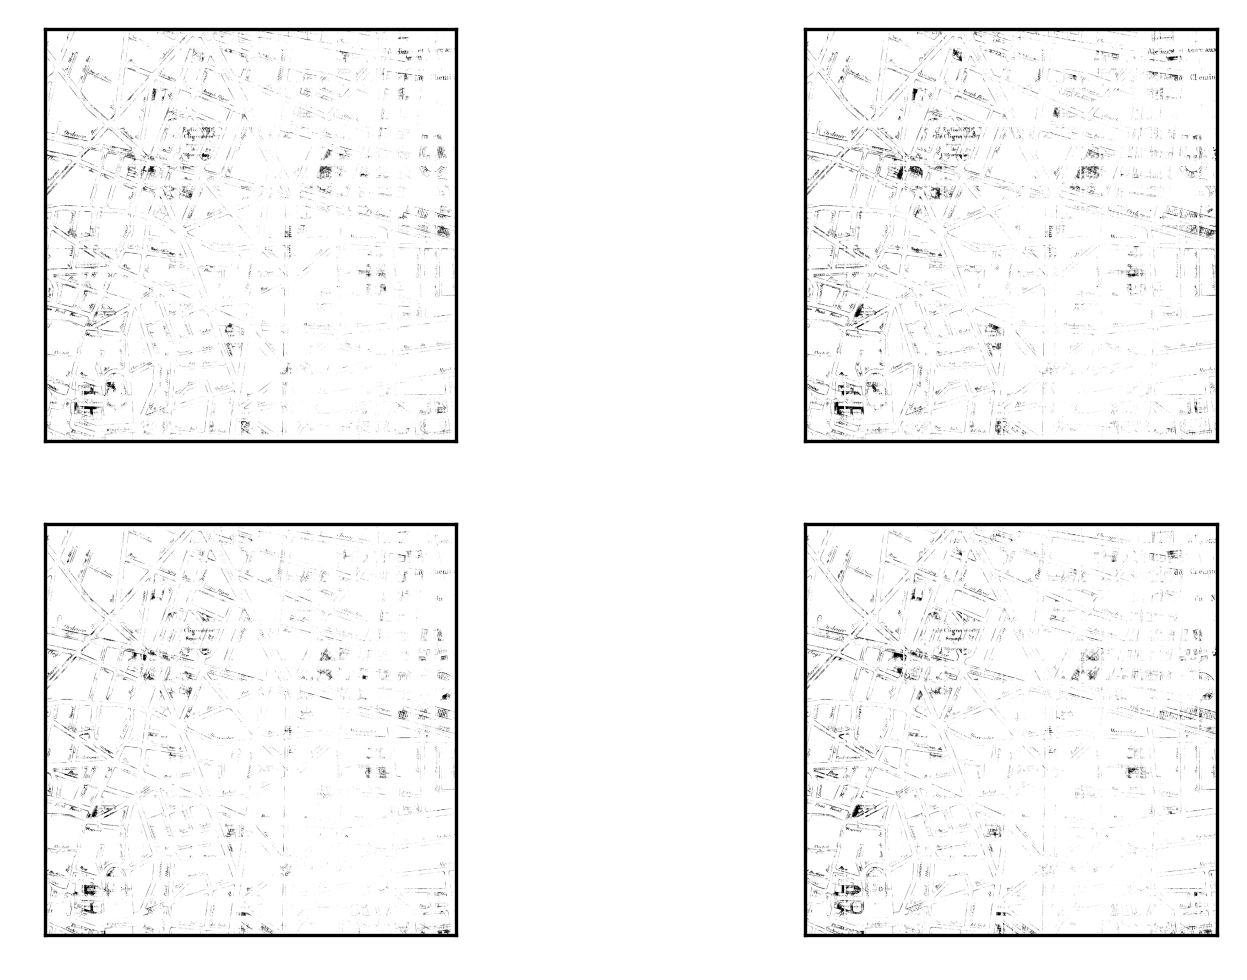

In [20]:
plot_side = int(np.sqrt(unified_predictions.shape[-1]))

fig, ax = plt.subplots(plot_side, plot_side, dpi=300)
i = 0
for row in range(plot_side):
    for col in range(plot_side):
        ax[row, col].imshow(unified_predictions[:, :, i])
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        i += 1
plt.show()

In [11]:
pixelwise_std = np.std(unified_predictions, axis=2)

In [12]:
pixelwise_std.shape

(2688, 2688)

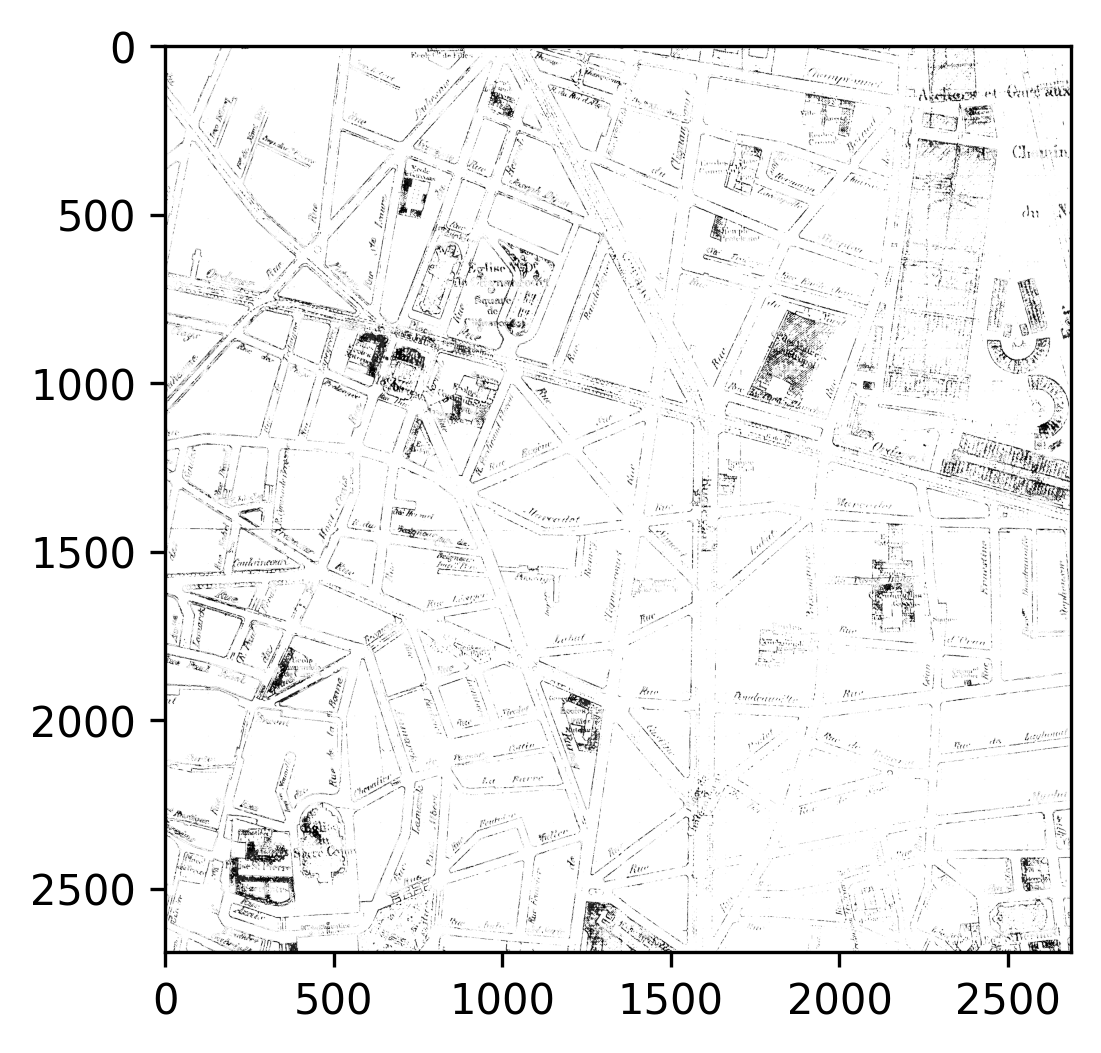

In [13]:
plt.figure(dpi=300)
plt.imshow(1-pixelwise_std, cmap='Greys_r')
plt.show()

In [ ]:
unified_predictions[2812:2820, 100, 0]